# Intent Classification with Small Transformers

In recent years, the transformer has been the go-to model in Natural Language Processing for almost all NLP tasks. Pretrained transformer models are easily available, but they are often large and fairly slow, which can make them hard to deploy. That's why a variety of smaller transformer models have emerged, which aim to compete with their bigger rivals, but at a lower computational cost. In this notebook we'll explore some of these smaller transformers. 

## Intent classification

We'll evaluate a range of pretrained transformer models on intent classification. Intent classification is a crucial task in the development of chatbots, where the computer needs to figure out how to respond to the input of a user. An interesting example dataset is `banking77`, which is available in the `datasets` library. It contains 13,083 customer service queries from the banking domain: 10,003 for training and 3080 for testing. Since there are 77 intents, it's a fairly challenging dataset.

In [1]:
from datasets import load_dataset

dataset = load_dataset('banking77')
dataset

Downloading:   0%|          | 0.00/2.34k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.75k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/158k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/51.1k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset banking77 downloaded and prepared to /home/ec2-user/.cache/huggingface/datasets/banking77/default/1.1.0/aec0289529599d4572d76ab00c8944cb84f88410ad0c9e7da26189d31f62a55b. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 10003
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 3080
    })
})

The intents cover a wide variety of banking topics, from `pin_blocked` to `declined_transfer` and `terminate_account`.

In [2]:
dataset["train"].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(num_classes=77, names=['activate_my_card', 'age_limit', 'apple_pay_or_google_pay', 'atm_support', 'automatic_top_up', 'balance_not_updated_after_bank_transfer', 'balance_not_updated_after_cheque_or_cash_deposit', 'beneficiary_not_allowed', 'cancel_transfer', 'card_about_to_expire', 'card_acceptance', 'card_arrival', 'card_delivery_estimate', 'card_linking', 'card_not_working', 'card_payment_fee_charged', 'card_payment_not_recognised', 'card_payment_wrong_exchange_rate', 'card_swallowed', 'cash_withdrawal_charge', 'cash_withdrawal_not_recognised', 'change_pin', 'compromised_card', 'contactless_not_working', 'country_support', 'declined_card_payment', 'declined_cash_withdrawal', 'declined_transfer', 'direct_debit_payment_not_recognised', 'disposable_card_limits', 'edit_personal_details', 'exchange_charge', 'exchange_rate', 'exchange_via_app', 'extra_charge_on_statement', 'failed_transfer', 'fiat_currency_support', 'get_disposa

The user inputs themselves are fairly short: they're questions like "What can I do if my card still hasn't arrived after 2 weeks?" or "How do I know if I will get my card, or if it is lost?" Every item has one label, which makes this a straightforward single-label classification task.

In [3]:
for item in dataset["train"]["text"][:5]:
    print(item)

I am still waiting on my card?
What can I do if my card still hasn't arrived after 2 weeks?
I have been waiting over a week. Is the card still coming?
Can I track my card while it is in the process of delivery?
How do I know if I will get my card, or if it is lost?


Let's take a look at the distribution of the labels. Many text classification problems are hard, not only because of the number of labels, but also because of their skewed distribution. Fortunately, the situation in the `banking77` dataset is not too bad: there's a handful of infrequent labels, but overall, the skew in the distribution is not very pronounced.

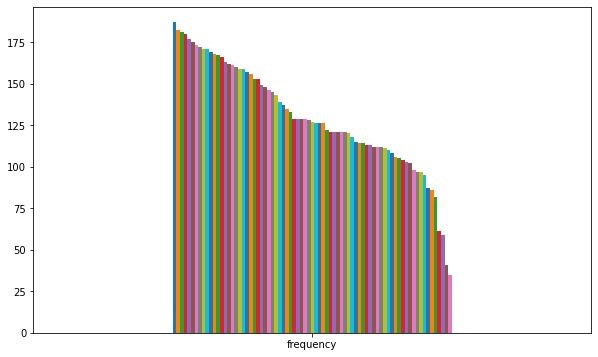

In [4]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter

train_texts = [item["text"] for item in dataset["train"]]
train_labels = [item["label"] for item in dataset["train"]]

test_texts = [item["text"] for item in dataset["test"]]
test_labels = [item["label"] for item in dataset["test"]]

label_counter = Counter(train_labels)
label_names = dataset["train"].features["label"].names
label_frequencies = {label_names[label]: [label_counter[label]] for label in label_counter}

df = pd.DataFrame.from_dict(label_frequencies, orient="index", columns=["frequency"])
df = df.sort_values("frequency", ascending=False)

plt.rcParams['figure.figsize'] = (10,6)
ax = df.transpose().plot(kind="bar", rot=0)
ax.get_legend().remove()

## Data preparation

Before we start training, we need to take a few preparatory steps. First of all, we set aside 10% of the training data as our development (or validation) set, which we'll use to evaluate the performance of the models during training. We keep the test set intact.

In [5]:
from sklearn.model_selection import train_test_split

train_texts, dev_texts, train_labels, dev_labels = train_test_split(train_texts, 
                                                                    train_labels, 
                                                                    test_size=0.1, 
                                                                    shuffle=True, 
                                                                    random_state=1)

print("Train:", len(train_texts))
print("Dev:", len(dev_texts))
print("Test:", len(test_texts))

Train: 9002
Dev: 1001
Test: 3080


Next, we define a dataset class to wrap the data in. When the model trainer gets an item from this class, it returns all information in the encoding (the token ids, the mask ids, etc.), together with the label.

In [6]:
import torch

class ClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['label'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

Finally, we define the metrics that we'll evaluate the models with. As this is a single-label classification task, we'll simply compute the overall accuracy of the model output.

In [7]:
from sklearn.metrics import accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc
    }

## Smaller transformers

We evaluate two types of small transformer models: ALBERT, and a family of smaller BERT models.
    
ALBERT was introduced in the paper [ALBERT: A Lite BERT for Self-supervised Learning of Language Representations](https://arxiv.org/abs/1909.11942). It uses various insights to shrink the footprint of a BERT model:

- In contrast to models like BERT and XLNet, it decouples the size of the token embeddings from the size of the hidden layer. This allows it to have a much smaller embedding layer, and therefore, a more efficient model.
- It further reduces BERT's memory requirements by sharing all parameters across layers. 

Finally, in pretraining, the original next-sentence prediction task is replaced by a sentence order prediction task, where the model has to decide whether two sentences are presented in their original order, or whether the order has been swapped. This obviously has no effect on the size or speed of the model, but is a more challenging pretraining task that forces the model to focus more on sentence coherence and not just sentence topic.

While the original BERT has 108M parameters, ALBERT-base has just 12M and ALBERT-large has 18M.

Another type of smaller BERT models was presented in the paper [Well-Read Students Learn Better: On the Importance of Pre-training Compact Models](https://arxiv.org/abs/1908.08962). The researchers combine pretraining with model distillation to train smaller models:

- In a first step, a compact model is pretrained using the well-known masked language modeling objective.
- In a second step, these small student models are further trained on the label probabilities (the so-called soft labels) that are produced by a larger teacher model.

We'll test models with four different sizes: BERT-tiny (4.4M parameters), BERT-mini (11.3M parameters), BERT-small (29.1M parameters), and BERT-medium (41.7M parameters). 

## Model training

We use the `transformer` library to train and evaluate all models. We train every model for 3 epochs with a batch size of 16, and evaluate every 50 steps. At the end of every training cycle, we evaluate the best checkpoint on the test data and remember the accuracy. 

In [10]:
from transformers import AutoTokenizer, Trainer, TrainingArguments, AutoModelForSequenceClassification

model_ids = ["prajjwal1/bert-tiny", "prajjwal1/bert-mini", 
             "prajjwal1/bert-small", "prajjwal1/bert-medium",
             "albert-base-v2", 
#              "albert-large-v2", "bert-base-uncased"
            ]

accuracies = []
for model_id in model_ids:
    
    print(f"*** {model_id} ***")

    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=len(label_names))

    train_texts_encoded = tokenizer(train_texts, padding=True, truncation=True, return_tensors="pt")
    dev_texts_encoded = tokenizer(dev_texts, padding=True, truncation=True, return_tensors="pt")
    test_texts_encoded = tokenizer(test_texts, padding=True, truncation=True, return_tensors="pt")
    
    train_dataset = ClassificationDataset(train_texts_encoded, train_labels)
    dev_dataset = ClassificationDataset(dev_texts_encoded, dev_labels)
    test_dataset = ClassificationDataset(test_texts_encoded, test_labels)
    
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=3,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=64,
        warmup_steps=int(len(train_dataset)/16),
        weight_decay=0.01,
        logging_dir='./logs',
        evaluation_strategy="steps",
        eval_steps=50,
        save_steps=50,
        save_total_limit=10,
        load_best_model_at_end=True,
        no_cuda=False
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        compute_metrics=compute_metrics,
        train_dataset=train_dataset,
        eval_dataset=dev_dataset,
    )

    trainer.train()
    test_results = trainer.evaluate(test_dataset)
    
    accuracies.append(test_results["eval_accuracy"])

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/config.json from cache at /home/ec2-user/.cache/huggingface/transformers/3cf34679007e9fe5d0acd644dcc1f4b26bec5cbc9612364f6da7262aed4ef7a4.a5a11219cf90aae61ff30e1658ccf2cb4aa84d6b6e947336556f887c9828dc6d
Model config BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



*** prajjwal1/bert-tiny ***


loading file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/vocab.txt from cache at /home/ec2-user/.cache/huggingface/transformers/585ac1c3dedc6b808dd35e8770afafe10905d3e723a02617af749d39db780e09.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/tokenizer.json from cache at None
loading file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/config.json from cache at /home/ec2-user/.cache/huggingface/transformers/3cf34679007e9fe5d0acd644dcc1f4b26bec5cbc9612364f6da7262aed4ef7a4.a5a11219cf90aae61ff30e1658ccf2cb4aa84d6b6e947336556f887c9828dc6d
Model config 

Step,Training Loss,Validation Loss,Accuracy
50,No log,4.351479,0.021978
100,No log,4.343233,0.021978
150,No log,4.329423,0.020979
200,No log,4.306545,0.020979


***** Running Evaluation *****
  Num examples = 1001
  Batch size = 512
Saving model checkpoint to ./results/checkpoint-50
Configuration saved in ./results/checkpoint-50/config.json
Model weights saved in ./results/checkpoint-50/pytorch_model.bin
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/ipykernel/__main__.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:64: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 1001
  Batch size = 512
Saving model checkpoint to ./results/checkpoint-100
Configuration saved 

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/prajjwal1/bert-mini/resolve/main/config.json from cache at /home/ec2-user/.cache/huggingface/transformers/a32529b12a03c02e99c269bf68c0c7b8349093f626e860ab9b012e3d9539c539.e6c2a1d71adb3143ecd42222c4604e92ff255a7663c04bb5c4fad770c78e096c
Model config BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "initializer_range": 0.02,
  "intermediate_size": 1024,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



*** prajjwal1/bert-mini ***


loading file https://huggingface.co/prajjwal1/bert-mini/resolve/main/vocab.txt from cache at /home/ec2-user/.cache/huggingface/transformers/62f8357e13eddc9798915fddaeb0de8bb9a14deda654be17fbfd049a56dd3b5a.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/prajjwal1/bert-mini/resolve/main/tokenizer.json from cache at None
loading file https://huggingface.co/prajjwal1/bert-mini/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/prajjwal1/bert-mini/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/prajjwal1/bert-mini/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/prajjwal1/bert-mini/resolve/main/config.json from cache at /home/ec2-user/.cache/huggingface/transformers/a32529b12a03c02e99c269bf68c0c7b8349093f626e860ab9b012e3d9539c539.e6c2a1d71adb3143ecd42222c4604e92ff255a7663c04bb5c4fad770c78e096c
Model config 

Step,Training Loss,Validation Loss,Accuracy
50,No log,4.348927,0.012987
100,No log,4.318354,0.022977
150,No log,4.259217,0.053946
200,No log,4.152870,0.097902


***** Running Evaluation *****
  Num examples = 1001
  Batch size = 512
Saving model checkpoint to ./results/checkpoint-50
Configuration saved in ./results/checkpoint-50/config.json
Model weights saved in ./results/checkpoint-50/pytorch_model.bin
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/ipykernel/__main__.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:64: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 1001
  Batch size = 512
Saving model checkpoint to ./results/checkpoint-100
Configuration saved 

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/prajjwal1/bert-small/resolve/main/config.json from cache at /home/ec2-user/.cache/huggingface/transformers/ac031779e2b4dd1d9da1e39c9d6a29fd45deea195eb3703a701d9c77f60abb4e.1257bb8f1f585038e86954d2560e36ca5c2dd98a8cde30fd22468940c911b672
Model config BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 2048,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 8,
  "num_hidden_layers": 4,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



*** prajjwal1/bert-small ***


loading file https://huggingface.co/prajjwal1/bert-small/resolve/main/vocab.txt from cache at /home/ec2-user/.cache/huggingface/transformers/68be80309844e53b628e9d479926a991d0adf337752bb941f0188887240313b8.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/prajjwal1/bert-small/resolve/main/tokenizer.json from cache at None
loading file https://huggingface.co/prajjwal1/bert-small/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/prajjwal1/bert-small/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/prajjwal1/bert-small/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/prajjwal1/bert-small/resolve/main/config.json from cache at /home/ec2-user/.cache/huggingface/transformers/ac031779e2b4dd1d9da1e39c9d6a29fd45deea195eb3703a701d9c77f60abb4e.1257bb8f1f585038e86954d2560e36ca5c2dd98a8cde30fd22468940c911b672
Model c

Step,Training Loss,Validation Loss,Accuracy
50,No log,4.363190,0.020979
100,No log,4.271223,0.042957
150,No log,4.059436,0.121878
200,No log,3.683882,0.335664


***** Running Evaluation *****
  Num examples = 1001
  Batch size = 512
Saving model checkpoint to ./results/checkpoint-50
Configuration saved in ./results/checkpoint-50/config.json
Model weights saved in ./results/checkpoint-50/pytorch_model.bin
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/ipykernel/__main__.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:64: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 1001
  Batch size = 512
Saving model checkpoint to ./results/checkpoint-100
Configuration saved 

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/prajjwal1/bert-medium/resolve/main/config.json from cache at /home/ec2-user/.cache/huggingface/transformers/288b0ee1e79a7c3fe770ab8a84ece013c573e7d226ccb5d9ffad317b3419faac.4344f82f77799c092b30b2e0d3749c809f82df14c5993e43dbbdc52f5a0d86e0
Model config BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 2048,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 8,
  "num_hidden_layers": 8,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



*** prajjwal1/bert-medium ***


loading file https://huggingface.co/prajjwal1/bert-medium/resolve/main/vocab.txt from cache at /home/ec2-user/.cache/huggingface/transformers/8e3007f026810a2525838fbc4c6f2abd96528541e780fc424859fa801cfe70ad.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/prajjwal1/bert-medium/resolve/main/tokenizer.json from cache at None
loading file https://huggingface.co/prajjwal1/bert-medium/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/prajjwal1/bert-medium/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/prajjwal1/bert-medium/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/prajjwal1/bert-medium/resolve/main/config.json from cache at /home/ec2-user/.cache/huggingface/transformers/288b0ee1e79a7c3fe770ab8a84ece013c573e7d226ccb5d9ffad317b3419faac.4344f82f77799c092b30b2e0d3749c809f82df14c5993e43dbbdc52f5a0d86e0
M

Step,Training Loss,Validation Loss,Accuracy
50,No log,4.317559,0.026973
100,No log,4.173368,0.083916
150,No log,3.826415,0.304695
200,No log,3.299040,0.527473


***** Running Evaluation *****
  Num examples = 1001
  Batch size = 512
Saving model checkpoint to ./results/checkpoint-50
Configuration saved in ./results/checkpoint-50/config.json
Model weights saved in ./results/checkpoint-50/pytorch_model.bin
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/ipykernel/__main__.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:64: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 1001
  Batch size = 512
Saving model checkpoint to ./results/checkpoint-100
Configuration saved 

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/albert-base-v2/resolve/main/config.json from cache at /home/ec2-user/.cache/huggingface/transformers/e48be00f755a5f765e36a32885e8d6a573081df3321c9e19428d12abadf7dba2.b8f28145885741cf994c0e8a97b724f6c974460c297002145e48e511d2496e88
Model config AlbertConfig {
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hidden_layers": 12,
  "num_memo

*** albert-base-v2 ***


loading file https://huggingface.co/albert-base-v2/resolve/main/spiece.model from cache at /home/ec2-user/.cache/huggingface/transformers/10be6ce6d3508f1fdce98a57a574283b47c055228c1235f8686f039287ff8174.d6110e25022b713452eb83d5bfa8ae64530995a93d8e694fe52e05aa85dd3a7d
loading file https://huggingface.co/albert-base-v2/resolve/main/tokenizer.json from cache at /home/ec2-user/.cache/huggingface/transformers/828a43aa4b9d07e2b7d3be7c6bc10a3ae6e16e8d9c3a0c557783639de9eaeb1b.670e237d152dd53ef77575d4f4a6cd34158db03128fe4f63437ce0d5992bac74
loading file https://huggingface.co/albert-base-v2/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/albert-base-v2/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/albert-base-v2/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/albert-base-v2/resolve/main/config.json from cache at /home/ec2-user/.cache/huggingface/transformer

Step,Training Loss,Validation Loss,Accuracy
50,No log,4.301930,0.037962
100,No log,4.128594,0.064935
150,No log,3.836816,0.159840
200,No log,3.437582,0.289710


***** Running Evaluation *****
  Num examples = 1001
  Batch size = 512
Saving model checkpoint to ./results/checkpoint-50
Configuration saved in ./results/checkpoint-50/config.json
Model weights saved in ./results/checkpoint-50/pytorch_model.bin
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/ipykernel/__main__.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:64: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 1001
  Batch size = 512
Saving model checkpoint to ./results/checkpoint-100
Configuration saved 

Let's take a look at the results. It's no surprise that BERT-base-uncased emerges as the best model: larger models have some clear advantages to their smaller competitors. At the other end of the spectrum, BERT-tiny and BERT-mini are definitely too small for this task. Still, the four models in the middle prove fairly strong competitors to BERT. The accuracy of BERT-small is around 6% lower than that of BERT, but BERT-medium is less than 3% behind. ALBERT is even closer, with ALBERT-base landing at less than 1.5% below the accuracy of the much larger BERT. In environments where there is not sufficient memory to run a full BERT, ALBERT-base may prove a very effictive solution indeed.

                          model
prajjwal1/bert-tiny    0.017857
prajjwal1/bert-mini    0.077922
prajjwal1/bert-small   0.318506
prajjwal1/bert-medium  0.460390
albert-base-v2         0.282143


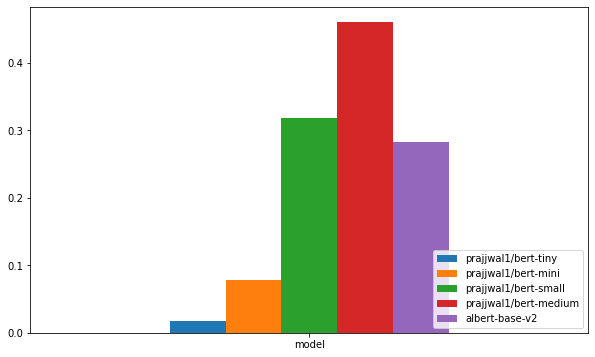

In [11]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({"model": accuracies}, index=model_ids)

print(df)
plt.rcParams['figure.figsize'] = (10,6)
ax = df.transpose().plot(kind="bar", rot=0)
ax.legend(loc=4)

## Conclusions

The huge transformer models that have become so popular in NLP, are often hard to deploy. Sometimes they're too slow to process enormous amounts of data cost-effectively, sometimes they need more memory than is available. In this notebook, we've explored some more efficient transformer models. An evaluation on intent classification shows that they can often hold their own against their larger competitors. 